In [11]:
# Needed to reload modified modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Evaluate the Encoder-Decoder models

import os
import numpy as np
import matplotlib.pyplot as plt
from local_utils import fast_tensor_load_encdec
from local_models import Tomoscope
# from local_utils import get_best_model_timestamp

data_dir = './tomo_data/datasets_tomoscope_TF_24-03-23'

train_cfg = {
    'normalization': 'minmax',
    'ps_normalize': 'off',
    'img_normalize': 'off',
    'dataset%': 0.1,
}

var_names = ['phEr', 'enEr', 'bl', 'inten', 'Vrf', 'mu', 'VrfSPS']

# enc_timestamp = get_best_model_timestamp('./trials', model='enc')
timestamp = '2023_06_21_13-25-59'



In [13]:
# Initialize parameters
import time

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
assert os.path.exists(ML_dir)

TESTING_PATH = os.path.join(ML_dir, 'tomoscope-testing-??.npz')

np.random.seed(0)

assert train_cfg['normalization'] == 'minmax'
assert train_cfg['img_normalize'] == 'off'
assert train_cfg['ps_normalize'] == 'off'

# First the training data

start_t = time.time()
wf_test, turn_test, latent_test, ps_test = fast_tensor_load_encdec(
    TESTING_PATH, train_cfg['dataset%'])
print('Number of Testing files: ', len(turn_test))
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(turn_test):.3f}')


Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-testing-00.npz
Number of Testing files:  139
Elapsed time: 4.910, Per file: 0.035


In [14]:
print('WF shape:', wf_test.shape)
print('Turn shape:', turn_test.shape)
print('Latent shape:', latent_test.shape)
print('PS shape:', ps_test.shape)

WF shape: (139, 128, 128, 1)
Turn shape: (139, 10)
Latent shape: (139, 7)
PS shape: (139, 128, 128, 10)


In [15]:
# Models to load
print('Tomoscope: ', timestamp)

# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
plots_dir = os.path.join('./trials/', timestamp, 'plots')
weights_dir = os.path.join(trial_dir, 'weights')

assert os.path.exists(weights_dir)
os.makedirs(plots_dir, exist_ok=True)

tomoscope = Tomoscope()
tomoscope.load(weights_dir=weights_dir)


Tomoscope:  2023_06_21_13-25-59


In [16]:
tomoscope.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 crop (Cropping2D)           (None, 128, 128, 1)       0         
                                                                 
 encoder_cnn_1 (Conv2D)      (None, 60, 60, 16)        1296      
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 60, 60, 16)        0         
                                                                 
 encoder_cnn_2 (Conv2D)      (None, 27, 27, 32)        25088     
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (None, 27, 27, 32)        0         
                                                                 
 encoder_cnn_3 (Conv2D)      (None, 12, 12, 64)        51200 

In [17]:

# Evaluate the model on the test and validation data
ps_pred = tomoscope.predict(wf_test)

# Evaluate the PS agreement
ps_mse = np.mean(np.square(ps_test[:, 14:-14, 14:-14] - ps_pred[:, 14:-14, 14:-14]), axis=0)
# ps_mse = np.mean((ps_test[:, 14:-14, 14:-14] - ps_pred[:, 14:-14, 14:-14])**2,
#                           axis=0).reshape((100, 100))
print('\nPS Tomoscope MSE: ', np.mean(ps_mse))


PS Tomoscope MSE:  6.409629e-06


PS True, min: 0.0, max: 0.20042000710964203
PS Pred, min: 0.0, max: 0.18873636424541473


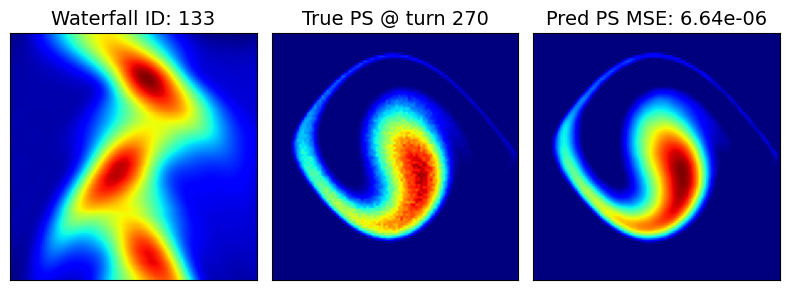

In [10]:
# Here we need animation with WF on the left, real PS in the middle, predicted on the right
'''
Visual end-to-end evaluation. 
Left: Waterfall (input)
Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
'''
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig, axes = plt.subplot_mosaic(mosaic=[['WF', 'PS_TRUE', 'PS_PRED']],
                               gridspec_kw={'width_ratios': [3, 3, 3]},
                               #        'hspace': 0.1, 'wspace': 0.2},
                               figsize=(8, 3.6)
                        )

# get random id
# sample_id = np.random.randint(low=0, high=len(wf_test))
sample_id = 133

wf_s = np.array(wf_test[sample_id, 14:-14, 14:-14]).reshape(100, 100).T

# turn_id = 9
ps_true_s = ps_test[sample_id, 14:-14, 14:-14]
ps_pred_s = ps_pred[sample_id, 14:-14, 14:-14]

# # start with left plot, the waterfall
plt.sca(axes['WF'])
plt.imshow(wf_s, cmap='jet')
plt.title(f'Waterfall ID: {sample_id}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])


# middle plot
plt.sca(axes['PS_TRUE'])
print(f'PS True, min: {np.min(ps_true_s)}, max: {np.max(ps_true_s)}')
middle_img = plt.imshow(ps_true_s[:, :, 0], cmap='jet')
plt.title(f'True PS @ turn 0', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

# right plot
plt.sca(axes['PS_PRED'])
print(f'PS Pred, min: {np.min(ps_pred_s)}, max: {np.max(ps_pred_s)}')
right_img = plt.imshow(ps_pred_s[:, :, 0], cmap='jet')
plt.title(f'Pred PS MSE:{np.mean((ps_pred_s[:, :, 0] - ps_true_s[:, :, 0])**2):.2e}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])
plt.tight_layout()
def animate(i):
    # update the data
    middle_img.set_data(ps_true_s[:, :, i])
    axes['PS_TRUE'].set_title(f'True PS @ turn {i*30}', fontsize=14)
    right_img.set_data(ps_pred_s[:, :, i])
    axes['PS_PRED'].set_title(f'Pred PS MSE: {np.mean((ps_pred_s[:, :, i] - ps_true_s[:, :, i])**2):.2e}', fontsize=14)
    return [middle_img, right_img]

# plt.tight_layout()
anim = animation.FuncAnimation(fig, animate, frames=ps_pred_s.shape[-1], 
                               interval=400, blit=True)
HTML(anim.to_html5_video())
anim.save(os.path.join(plots_dir, f'tomoscope{timestamp}_wf{sample_id}.gif'), dpi=400)
# plt.savefig(os.path.join(plots_dir, f'encDec_id{sample_id}_turn{turn_s}.jpg'), dpi=400)


In [16]:
from mlp_lhc_tomography.utils import assess_decoder
num_samples = 20
assess_decoder(ps_pred[:num_samples], turn_test[:num_samples], ps_test[:num_samples],
               plots_dir=plots_dir, savefig=True)


In [13]:
from mlp_lhc_tomography.utils import assess_model
num_samples = 20
assess_model(ps_pred[:num_samples], turn_test[:num_samples], wf_test[:num_samples], ps_test[:num_samples],
             plots_dir=plots_dir, savefig=True, with_projections=True)
